In [10]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras import datasets
from matplotlib import pyplot
import tensorflow as tf
import imageio
import PIL
import glob
from IPython import display

In [11]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Download dataset

In [12]:
from PIL import Image
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd 
from sklearn.metrics import accuracy_score

In [13]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [14]:
#Fetch images deom GTSRB website
#Images for training
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation    
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LOC - https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

** Resuming transfer from byte position 276294756
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 88978620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (33) HTTP server doesn't seem to support byte ranges. Cannot resume.
** Resuming transfer from byte position 99620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:-- 

In [15]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR)
]
 
for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

Unzipping GTSRB_Final_Training_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_Images.zip to dataset/tmp...
Unzipping GTSRB_Final_Test_GT.zip to dataset/tmp/GTSRB/Final_Test...
CPU times: user 7.37 s, sys: 2.2 s, total: 9.57 s
Wall time: 9.64 s


In [16]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [17]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 10.4 s, sys: 2.03 s, total: 12.5 s
Wall time: 12.5 s


In [18]:
# Print all categories with example image for each of them.
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

train_images = []
for training_dir in preprocessed_training_dirs:
    train_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/256)
image_data = image_generator.flow_from_directory(str(TRAINING_DATA_DIR), target_size=(32, 32))

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 39209 images belonging to 43 classes.
Image batch shape:  (32, 32, 32, 3)
Label batch shape:  (32, 43)


In [19]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [20]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
test_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    test_images.append(final_image)
    test_images.sort()
    
print("Validation images count:", len(test_images))

Validation images count: 12630
CPU times: user 5.52 s, sys: 762 ms, total: 6.29 s
Wall time: 6.29 s


# Load data

In [21]:
from skimage import color, exposure, transform
from skimage import io
import os
import glob
import matplotlib.image as mpimg

def preprocess_img(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (32, 32))

    return img


def get_class(img_path):
    return int(img_path.split(os.sep)[-2])

In [22]:
root_dir = 'dataset' + os.sep + 'training' + os.sep

imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.jpg'))

np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(mpimg.imread(img_path))
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
# Make one hot targets
Y = np.eye(43, dtype='uint8')[labels]

print(len(X))

# Split data into training and validation (test) set
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

39209


31367


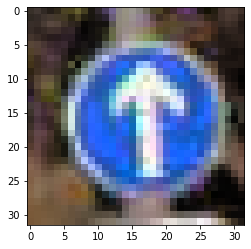

In [23]:
print(len(train_images))
image = train_images[1000]

pyplot.imshow(image[:, :, :])

# Defining discriminator and generator

In [33]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    # # upsample to 8x8
    # model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    # model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# use the generator to generate n fake examples for GIF
def generate_gif_images(g_model, n_samples):
    # predict outputs
    X = g_model.predict(seed)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y


# create and save a plot of generated images
def save_plot(examples, epoch, n=3):
    # # Reshape from [-1,1] to [0,1]
    # examples = (examples + 1) / 2

    # plot images
    pyplot.figure(figsize=(8,8))
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, :])

    # save plot to file
    filename = 'Generated images/generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)

    pyplot.show()


# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('> epoch:', (epoch+1) ,' Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    x_gif_images, y_gif_images = generate_gif_images(g_model, 9)
    save_plot(x_gif_images, epoch)
    # save the generator model tile file
    filename = 'Trained models/generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2.0)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Log training stats
            with summary_writer.as_default():
                tf.summary.scalar('gen_loss', g_loss, step=i)
                tf.summary.scalar('disc_loss_real', d_loss1, step=i)
                tf.summary.scalar('disc_loss_fake', d_loss2, step=i)

        # print model performance, sometimes
        if (i+1) % 1 == 0:
            display.clear_output(wait=True)
            summarize_performance(i, g_model, d_model, dataset, latent_dim, 9)

# Train models

In [34]:
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)

n_samples = 9
latent_dim = 100

# generate points in the latent space
seed = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network
seed = seed.reshape(n_samples, latent_dim)

In [35]:
EPOCHS = 200
# size of the latent space
latent_dim = 100
# create the discriminator
from keras.models import load_model
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# g_model = load_model('generator_model_200.h5')
# create the gan
gan_model = define_gan(g_model, d_model)

In [ ]:
# Log training stats
import datetime
log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(
log_dir + datetime.datetime.now().strftime("%d-%m-%Y %H:%M:%S"))

# Create new output folders
os.makedirs('Generated images')
os.makedirs('Trained models')

# Open Tensorboard
%tensorboard --logdir logs

In [ ]:
# train model
train(g_model, d_model, gan_model, train_images, latent_dim, EPOCHS)

## Create a GIF

In [ ]:
# # To generate GIFs
# !pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [ ]:
# Display a single image using the epoch number
def display_image(epoch):
  return PIL.Image.open('Generated images/generated_plot_e%03d.png' % (epoch-1))

In [ ]:
display_image(60)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('Generated images/generated_plot*.png')
  filenames = sorted(filenames)
  for index, filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    if index == EPOCHS:
        break
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)